In [1]:
import sys
import os

In [2]:
curr_dir = sys.path[0]

src_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
main_dir = os.path.abspath(os.path.join(src_dir, os.pardir))
notebooks_dir = os.path.join(main_dir, 'notebooks')

In [3]:
curr_dir

'/home/baambriz/q2_code/src/analysis'

In [4]:
sys.path.append(os.path.realpath('../../config'))

In [5]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
local = False
from GraphDataset import GraphDataset

# loading q1 results

### Fully Connected NN

In [6]:
fcnn_predictions = pd.read_csv(main_dir + '/fcnn_predictions.csv', index_col = False)

In [7]:
fcnn_predictions.shape

(4679, 6)

In [8]:
fcnn_predictions.head()

,hbb_prediction,qcd_prediction,truth_hbb_label,truth_qcd_label,Mass,Momentum_pt
0,0.635317,0.364683,0.0,1.0,119.241837,1561.307129
1,0.923382,0.076618,0.0,1.0,102.725922,1225.894531
2,0.976005,0.023995,1.0,0.0,111.213684,543.558716
3,0.932751,0.067249,1.0,0.0,87.718056,1528.039185
4,0.984916,0.015084,1.0,0.0,45.537159,540.035828


### Deep Sets NN

In [9]:
dsnn_predictions = pd.read_csv(main_dir + '/dsnn_predictions.csv', index_col=False)

In [10]:
dsnn_predictions.shape

(4679, 6)

In [11]:
dsnn_predictions.head()

,hbb_prediction,qcd_prediction,truth_hbb_label,truth_qcd_label,Mass,Momentum_pt
0,0.368562,0.631438,0.0,1.0,119.241837,1561.307129
1,0.235360,0.764640,0.0,1.0,102.725922,1225.894531
2,0.871025,0.128975,1.0,0.0,111.213684,543.558716
3,0.673200,0.326800,1.0,0.0,87.718056,1528.039185
4,0.795255,0.204745,1.0,0.0,45.537159,540.035828


# loading q2 results

### Graph NN 

In [12]:
graph_predictions = pd.read_csv(main_dir + '/GENConv_predictions.csv', index_col=False)

In [13]:
graph_predictions.shape

(1889, 5)

In [14]:
graph_predictions

,hbb_prediction,truth_hbb_label,truth_qcd_label,Mass,Momentum_pt
0,-4.199533,0,1,1.411147,1067.30180
1,-7.378573,0,1,3.423921,541.63330
2,-3.654222,0,1,5.067724,800.68677
3,-4.542435,0,1,71.291230,730.17760
4,-2.095073,0,1,0.000003,444.05510
...,...,...,...,...,...
1884,-3.887362,0,1,13.505009,948.92720
1885,-3.413397,0,1,7.528856,202.73802
1886,-4.640887,0,1,7.864277,403.12040
1887,-6.264555,0,1,3.470626,370.88480


In [16]:
import torch
graph_predictions['hbb_sig'] = torch.nn.Sigmoid()(torch.tensor(graph_predictions['hbb_prediction']))
graph_predictions['qcd_sig'] = 1 - graph_predictions['hbb_sig']

In [17]:
graph_predictions.head()

,hbb_prediction,truth_hbb_label,truth_qcd_label,Mass,Momentum_pt,hbb_sig,qcd_sig
0,0.014781,0,1,1.411147,1067.30180,0.503695,0.496305
1,0.000624,0,1,3.423921,541.63330,0.500156,0.499844
2,0.025229,0,1,5.067724,800.68677,0.506307,0.493693
3,0.010535,0,1,71.291230,730.17760,0.502634,0.497366
4,0.109577,0,1,0.000003,444.05510,0.527367,0.472633


## Evaluation / Comparison

### Graph of AUC

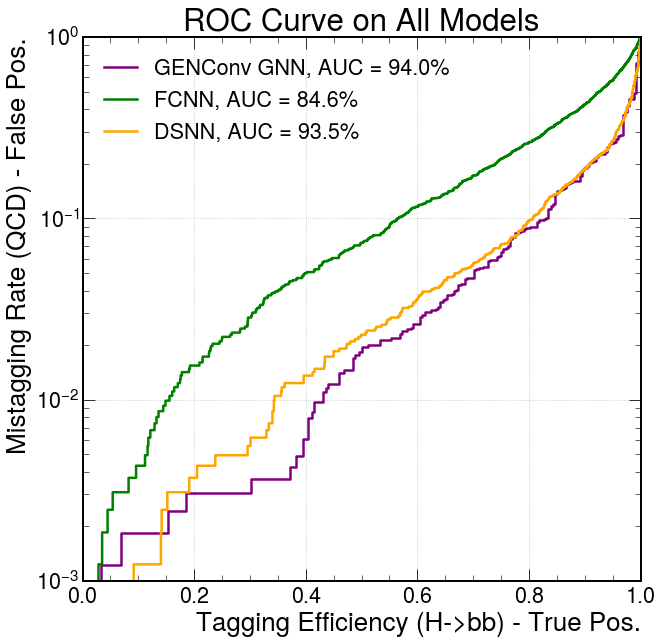

In [89]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['truth_hbb_label'], graph_predictions['hbb_sig'])
fpr_fcnn, tpr_fcnn, threshold_fcnn = roc_curve(fcnn_predictions['truth_hbb_label'], fcnn_predictions['hbb_prediction'] )
fpr_dsnn, tpr_dsnn, threshold_dsnn = roc_curve(dsnn_predictions['truth_hbb_label'], dsnn_predictions['hbb_prediction'])
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GENConv GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), c = 'purple')
plt.plot(tpr_fcnn, fpr_fcnn, lw=2.5, label="FCNN, AUC = {:.1f}%".format(auc(fpr_fcnn,tpr_fcnn)*100), c = 'green')
plt.plot(tpr_dsnn, fpr_dsnn, lw=2.5, label="DSNN, AUC = {:.1f}%".format(auc(fpr_dsnn,tpr_dsnn)*100), c = 'orange')
plt.xlabel(r'Tagging Efficiency (H->bb) - True Pos.')
plt.ylabel(r'Mistagging Rate (QCD) - False Pos.')
plt.title('ROC Curve on All Models')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('roc_curve_no_ddt.jpg')
plt.show()

### Graph of ROC using DDT (Designed Decorrelated Taggers) Procedure

In [19]:
from utils import find_nearest

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

DDT Procedure

1. Bin the mass 10 bins / size 20 
2. Select the data from each bin
3. Per bin, find the threshold hbb-sig which corresponds closely to a 1% fpr
4. Per bin, find the sum or total # of true-labeled hbb events that achieve the threshold 
5. In #4 (divided by total number of signal events in all bins)


In [20]:
#adding data not included in prediction output of GNN
graph_predictions['Bin_quantile'] = pd.qcut(graph_predictions['Mass'], q=10)

In [21]:
##adding data not included in predition output of FCNN/DSNN
fcnn_predictions['Bin_quantile'] = pd.qcut(fcnn_predictions['Mass'], q=10)
dsnn_predictions['Bin_quantile'] = pd.qcut(dsnn_predictions['Mass'], q=10)

In [22]:
graph_predictions.head()

,hbb_prediction,truth_hbb_label,truth_qcd_label,Mass,Momentum_pt,hbb_sig,qcd_sig,Bin_quantile
0,0.014781,0,1,1.411147,1067.30180,0.503695,0.496305,"(-0.0010305, 2.887]"
1,0.000624,0,1,3.423921,541.63330,0.500156,0.499844,"(2.887, 5.857]"
2,0.025229,0,1,5.067724,800.68677,0.506307,0.493693,"(2.887, 5.857]"
3,0.010535,0,1,71.291230,730.17760,0.502634,0.497366,"(61.257, 91.323]"
4,0.109577,0,1,0.000003,444.05510,0.527367,0.472633,"(-0.0010305, 2.887]"


In [61]:
def ddt_find_fpr(cutoffs, data):
    tprs = []
    threshes_lowest = []
    for cut in cutoffs:
        total_above = 0
        total = 0
        threshes_per_cut = []
        #iterating over each bin (in this case bin by quant.)
        for bin_group, df in data.groupby('Bin_quantile'):
            #using roc curve to find fpr/tpr rates
            fpr_ddt, tpr_ddt, threshold_ddt = roc_curve(df['truth_hbb_label'], df['hbb_prediction'])
            #using find nearest function to identify where fpr meets cut thresh
            idx_ddt, val_ddt = find_nearest(fpr_ddt, cut)
            #using 'truth' or eval. labels, identify the predictions meeting thresh/cut
            datas_above_thresh = df['truth_hbb_label']*(df['hbb_prediction'] > threshold_ddt[idx_ddt])
            threshes_per_cut.append(idx_ddt)
            #avg num above / total num events for truth/eval
            num_datas_above_thresh = datas_above_thresh.sum()
            total_above += num_datas_above_thresh
            total += df['truth_hbb_label'].sum()
        threshes_lowest.append(threshes_per_cut[0])
        true_pos_rate = total_above / total
        tprs.append(true_pos_rate)
    return np.array(tprs), threshes_lowest

In [62]:
ddt_fpr = np.arange(0,1,0.01)

In [63]:
ddt_gnn_tpr, thresholds_ddt_gnn = ddt_find_fpr(ddt_fpr, graph_predictions)
ddt_dsnn_tpr, thresholds_ddt_dsnn = ddt_find_fpr(ddt_fpr, dsnn_predictions)
ddt_fcnn_tpr, thresholds_ddt_fcnn = ddt_find_fpr(ddt_fpr, fcnn_predictions)

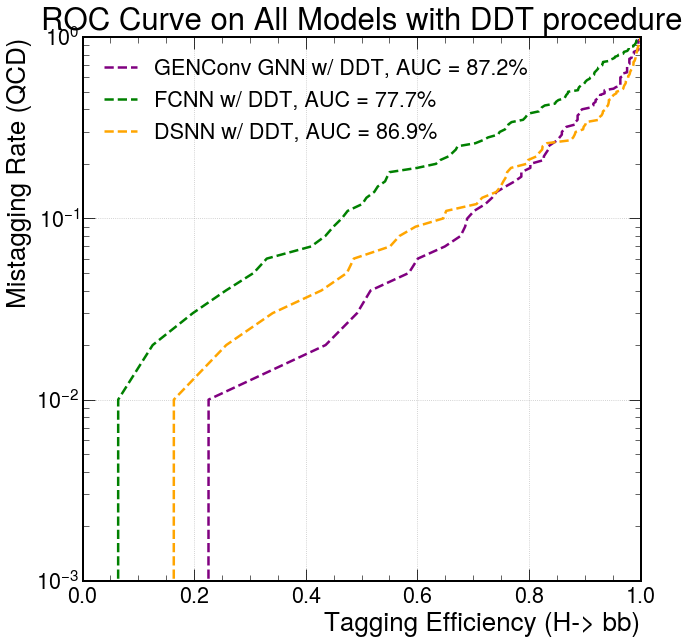

In [90]:
# plot curves
plt.figure()
plt.plot(ddt_gnn_tpr, ddt_fpr, color = 'purple', linestyle = '--', lw=2.5, label="GENConv GNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_gnn_tpr)*100))
plt.plot(ddt_fcnn_tpr, ddt_fpr, color = 'green', linestyle = '--', lw=2.5, label="FCNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_fcnn_tpr)*100))
plt.plot(ddt_dsnn_tpr, ddt_fpr, color = 'orange', linestyle = '--', lw=2.5, label="DSNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_dsnn_tpr)*100))
plt.xlabel(r'Tagging Efficiency (H-> bb)')
plt.ylabel(r'Mistagging Rate (QCD)')
plt.title('ROC Curve on All Models with DDT procedure')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('roc_curve_ddt_only.jpg')
plt.show()

### Combined ROC/AUC plot of GENConv GNN model with & without DDT procedure

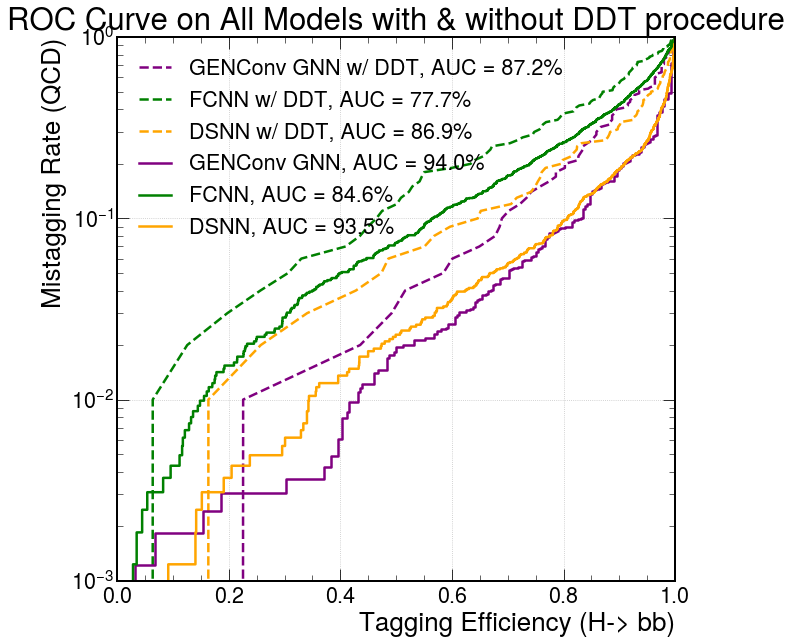

In [91]:
# plot curves
plt.figure()
plt.plot(ddt_gnn_tpr, ddt_fpr, color = 'purple', linestyle = '--', lw=2.5, label="GENConv GNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_gnn_tpr)*100))
plt.plot(ddt_fcnn_tpr, ddt_fpr, color = 'green', linestyle = '--', lw=2.5, label="FCNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_fcnn_tpr)*100))
plt.plot(ddt_dsnn_tpr, ddt_fpr, color = 'orange', linestyle = '--', lw=2.5, label="DSNN w/ DDT, AUC = {:.1f}%".format(auc(ddt_fpr, ddt_dsnn_tpr)*100))
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GENConv GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), c = 'purple')
plt.plot(tpr_fcnn, fpr_fcnn, lw=2.5, label="FCNN, AUC = {:.1f}%".format(auc(fpr_fcnn,tpr_fcnn)*100), c = 'green')
plt.plot(tpr_dsnn, fpr_dsnn, lw=2.5, label="DSNN, AUC = {:.1f}%".format(auc(fpr_dsnn,tpr_dsnn)*100), c = 'orange')
plt.xlabel(r'Tagging Efficiency (H-> bb)')
plt.ylabel(r'Mistagging Rate (QCD)')
plt.title('ROC Curve on All Models with & without DDT procedure')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('combined_roc_curve.jpg')
plt.show()

### Combined Plot of Mass Distribution of H-bb jets of GNN predictions

In [59]:
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['truth_hbb_label'], graph_predictions['hbb_sig'])

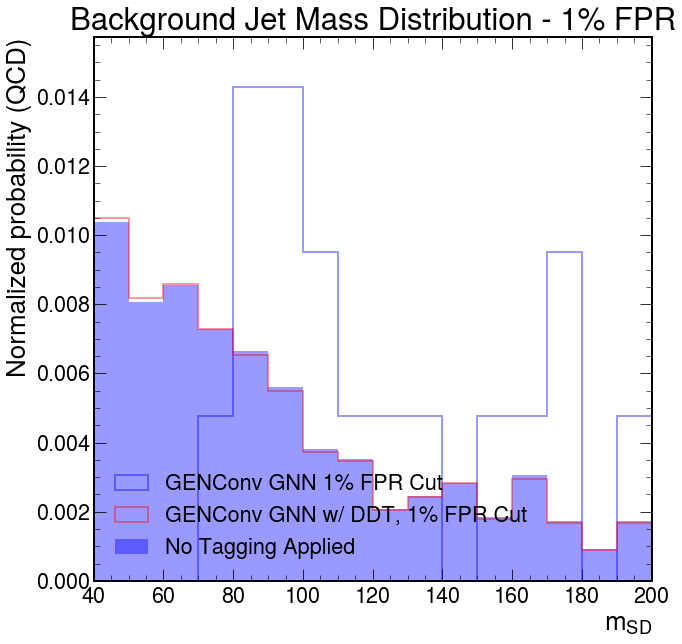

In [92]:
plt.figure()
for wp in [0.01]:
    idx_gnn, val_gnn = find_nearest(fpr_gnn, wp)
    plt.hist(graph_predictions['Mass'], bins=np.linspace(20, 220, 21), 
             weights=graph_predictions['truth_qcd_label']*(graph_predictions['hbb_prediction'] > threshold_gnn[idx_gnn]),
             alpha=0.4, density=True, color = 'blue',label='GENConv GNN {}% FPR Cut'.format(int(wp*100)), histtype='step', linewidth = 2)
    plt.hist(graph_predictions['Mass'], bins=np.linspace(20, 220, 21), 
             weights= graph_predictions['truth_qcd_label'] * (graph_predictions['hbb_prediction'] > thresholds_ddt_gnn[0]),
             alpha=0.4, density=True, color = 'red',label='GENConv GNN w/ DDT, {}% FPR Cut'.format(int(wp*100)),histtype='step', linewidth = 2)
plt.hist(graph_predictions['Mass'], bins=np.linspace(20, 220, 21), 
         weights=graph_predictions['truth_qcd_label']*(graph_predictions['hbb_sig']),
         alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
plt.title("Background Jet Mass Distribution - 1% FPR")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (QCD)')
plt.xlim(40, 200)
plt.savefig('background_mass.jpg')
plt.show()

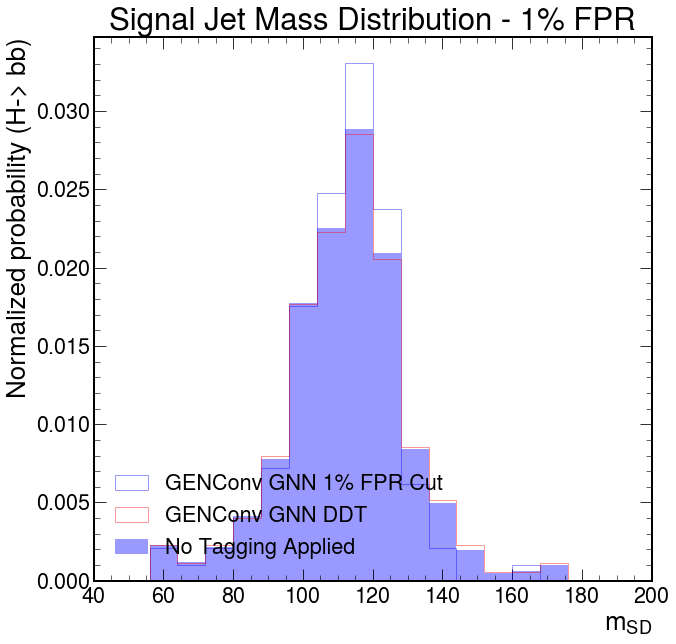

In [93]:
plt.figure()
for wp in [0.01]:
    idx_gnn, val_gnn = find_nearest(fpr_gnn, wp)
    plt.hist(graph_predictions['Mass'], bins=np.linspace(40, 200, 21), 
             weights=graph_predictions['truth_hbb_label']*(graph_predictions['hbb_prediction'] > threshold_gnn[idx_gnn]),
             alpha=0.4, density=True, color = 'blue', label='GENConv GNN {}% FPR Cut'.format(int(wp*100)), histtype='step')
    plt.hist(graph_predictions['Mass'], bins=np.linspace(40, 200, 21), 
             weights=graph_predictions['truth_hbb_label'] * (graph_predictions['hbb_prediction'] > thresholds_ddt_gnn[0]),
             alpha=0.4, density=True, color='red', label='GENConv GNN DDT'.format(int(wp*100)),histtype='step')
plt.hist(graph_predictions['Mass'], bins=np.linspace(40, 200, 21), 
         weights=graph_predictions['truth_hbb_label']*(graph_predictions['hbb_sig']),
         alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
plt.title("Signal Jet Mass Distribution - 1% FPR")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (H-> bb)')
plt.xlim(40, 200)
plt.savefig('signal_mass.jpg')
plt.show()